In [567]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pprint 
import sklearn.naive_bayes as nb
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from patsy import dmatrix
from numpy.linalg import inv
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import sklearn.linear_model
from pybaseball import statcast

# Linear Regression on Minimizing Launch Speed
## Data Description
Once again, using data from Major League Baseball. This time, **the outcome variable of interest is "Launch Speed (Translation: How hard was the ball hit?)"** It's a well documented fact that successful hitting in baseball can be best predicted through launch speed and angle, from a hitter's perspective. However, in this question I want to see if there are any factors a pitcher can control to minimize a hitter's success at the plate, and in particular limit their exit velocity/launch speed.
It would take beyond the scope of this assignment to explain what each of the input variables are, but rest assured they're various continuous metrics of a pitch, all of which are controlled by the pitcher.

In [603]:
data = statcast('2021-06-20', '2021-06-30')

This is a large query, it may take a moment to complete


100%|██████████| 11/11 [00:10<00:00,  1.08it/s]


In [604]:
df = data[['release_spin_rate','release_extension', 'release_speed', 'release_pos_y', 'release_pos_x',
       'release_pos_z', 'plate_x','plate_z','launch_speed']].dropna()
X = df.drop(columns = ['launch_speed'])
y = df[['launch_speed']].values

## Scale, Train/Test Split

In [605]:
mm = MinMaxScaler()
X = mm.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state = 42, test_size = .3)

## Fit, Predict, Score for Linear Regressor

In [606]:
lr = LinearRegression()
lr.fit(X_train, y_train)
train_preds = lr.predict(X_train)
test_preds = lr.predict(X_test)
print('LinearRegression Train Mean Squared Error: %.4f' %np.mean((y_train - train_preds)**2))
print('LinearRegression Test Mean Squared Error: %.4f' %np.mean((y_test - test_preds)**2))

LinearRegression Train Mean Squared Error: 243.4919
LinearRegression Test Mean Squared Error: 246.2041


In [623]:
scores = sklearn.model_selection.cross_validate(lr, X, y, cv=10,
                                                scoring=('r2', 'neg_mean_squared_error'))
print('Mean MSE: %.2f' %np.mean(-scores['test_neg_mean_squared_error']))

Mean MSE: 244.77


In [611]:
las_r = sklearn.linear_model.Lasso()
las_r.fit(X_train, y_train)
las_train_preds = las_r.predict(X_train)
las_test_preds = las_r.predict(X_test)
print('Lasso Train Mean Squared Error: %.4f' %np.mean((y_train - las_train_preds)**2))
print('Lasso Test Mean Squared Error: %.4f' %np.mean((y_test - las_test_preds)**2))

Lasso Train Mean Squared Error: 245.4785
Lasso Test Mean Squared Error: 247.0360


In [607]:
rr = sklearn.linear_model.Ridge()
rr.fit(X_train, y_train)
ridge_train_preds = rr.predict(X_train)
ridge_test_preds = rr.predict(X_test)
print('Ridge Train Mean Squared Error: %.4f' %np.mean((y_train - ridge_train_preds)**2))
print('Ridge Test Mean Squared Error: %.4f' %np.mean((y_test - ridge_test_preds)**2))

Lasso Train Mean Squared Error: 243.4949
Lasso Test Mean Squared Error: 246.2061


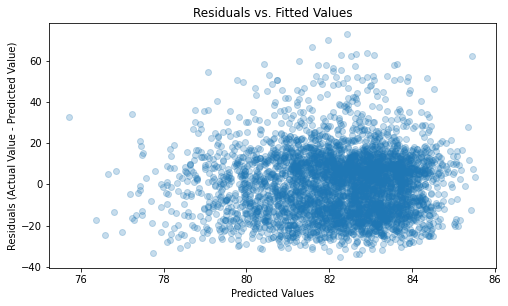

In [638]:
residuals = test_preds - y_test
fig, ax = plt.subplots(figsize = (8,4.5))
ax.scatter(test_preds, residuals, alpha = .25)
ax.set_xlabel("Predicted Values")
ax.set_ylabel("Residuals (Actual Value - Predicted Value)")
ax.set_title("Residuals vs. Fitted Values")
plt.show()

In [642]:
param_grid =  {'alpha': [float(i) for i in range(50)]}
grid_search = GridSearchCV(rr, param_grid)
grid_search.fit(X_train, y_train)
print("Best Estimator:", grid_search.best_estimator_)
print("Best Parameters for Ridge:", grid_search.best_params_)
best_preds = grid_search.best_estimator_.predict(X_test)
print('Ridge Test Mean Squared Error: %.4f' %np.mean((y_test - best_preds)**2))

Best Estimator: Ridge(alpha=29.0)
Best Parameters for Ridge: {'alpha': 29.0}
Ridge Test Mean Squared Error: 246.0813


In [656]:
param_grid =  {'alpha': [float(i) / 100 for i in range(1,100)]}
grid_search = GridSearchCV(las_r, param_grid)
grid_search.fit(X_train, y_train)
print("Best Estimator:", grid_search.best_estimator_)
print("Best Parameters for Lasso:", grid_search.best_params_)
best_preds = grid_search.best_estimator_.predict(X_test)
print('Lasso Test Mean Squared Error: %.4f' %np.mean((y_test - best_preds)**2))

Best Estimator: Lasso(alpha=0.02)
Best Parameters for Lasso: {'alpha': 0.02}
Lasso Test Mean Squared Error: 248.3844
